# 1D Autotetraploid Validation and Associated Testing

This includes validation of my WF models, numerical diffusion solution, and other tests (e.g. mass conservation and changes to selection and variance). This uses a combination of numerical approximations to analytical solutions, sanity checks, clever comparisons, plots, and mean/variance calculations for phi using trapezoid integration. 

In [2]:
import numpy as np
import dadi 
from matplotlib import pyplot as plt
from dadi.Polyploids.Old_Int_const_params import integration_OLD as poly_int
from dadi.Polyploids import wrightfisher as WF
from dadi.Polyploids import kimura_analytic


## 1D Diploid Model Validation

Since we know the dadi code is correct, it makes sense to also test the WF model I developed, so let's do that before handling the autotetraploid things.

Retained density is: 0.5189618130221959
Mean of final allele frequency: 0.5820647602557054
Variance of final allele frequency: 0.0792724353591488


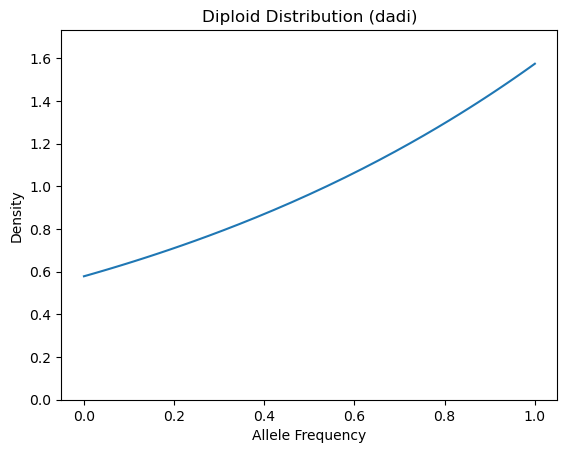

In [ ]:
# it's not as easy to calculate the retained density when using the default exponential grid from dadi
# so, I instead use a simple linspace, which seems to work fine here (particularly when theta0=0)
# this also makes it very convenient to assign specific initial conditions/initial phi for testing the WF sims
# xx = np.linspace(0, 1, 101)

# I have since figured out that it is not hard to compute the maintained density, at least in 1D, so let's test on the dadi grid
xx = dadi.Numerics.default_grid(pts=101)

# set up a dirac delta type phi
phi = np.zeros_like(xx)
phi[50] = 1

prelim_density = np.trapz(phi, xx)

# Diploid integration example with dadi
phi = dadi.Integration._one_pop_const_params(phi, xx, T = 1, nu = 1, gamma = 1, h=0.5, theta0 = 0)

# prints how much mass is retained (i.e. not lost at x=0 or x=1)
print(f"Retained density is: {np.trapz(phi, xx)/prelim_density}")

WF.summarize_phi(phi, xx, 'Diploid Distribution (dadi)')

Retained density is: 0.51561
Mean final allele frequency: 0.5827633676616047
Variance of final allele frequency: 0.07876680946546497


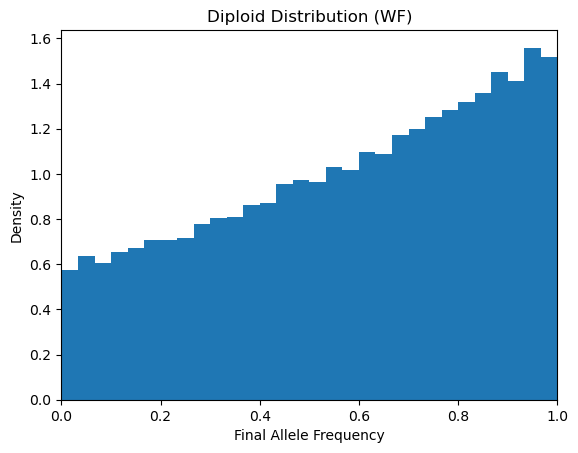

In [3]:
# Compare dadi integration to WF model
dip_WF = WF.dip_allelic_WF(N=1000, T=1, gamma = 1, h=0.5, init_q = np.full(100000, .5), replicates=100000)
# extract final frequencies and mask/remove 0 and 1 entries
final_polymorphic = WF.mask(dip_WF)

# calculate how much frequency is retained
print(f"Retained density is: {final_polymorphic.size/dip_WF.size}")

# Compute and print mean and variance to compare to the above
print(f"Mean final allele frequency: {np.mean(final_polymorphic)}")
print(f"Variance of final allele frequency: {np.var(final_polymorphic)}")

# Plot histogram of final allele frequencies
plt.hist(final_polymorphic, bins = 30, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Diploid Distribution (WF)')
plt.xlim(0, 1)
plt.show()

## 1D Autotetraploid Model Validation

Here, I compare the gametic and allelic WF models I developed. Then, I also validate this against my diffusion approximation solution implemented in dadi. 

### Gametic and Allelic Model Validation

First, let's focus on comparing results from the two different WF models.


Allele model results
Mean final allele frequency: 0.3944548768583109
Variance of final allele frequency: 0.04909872547732463


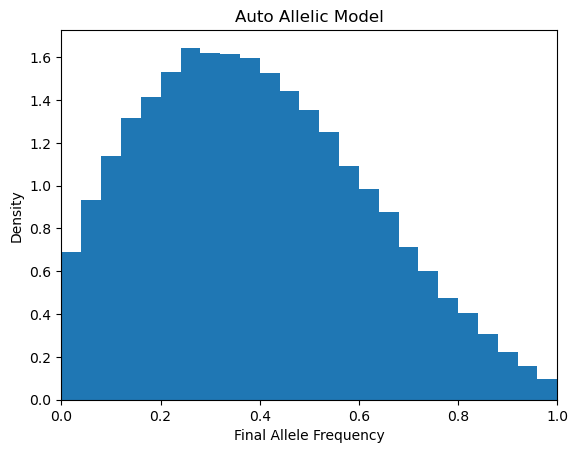

Gamete model results
Mean final allele frequency: 0.3953392217427589
Variance of final allele frequency: 0.04914026151563014


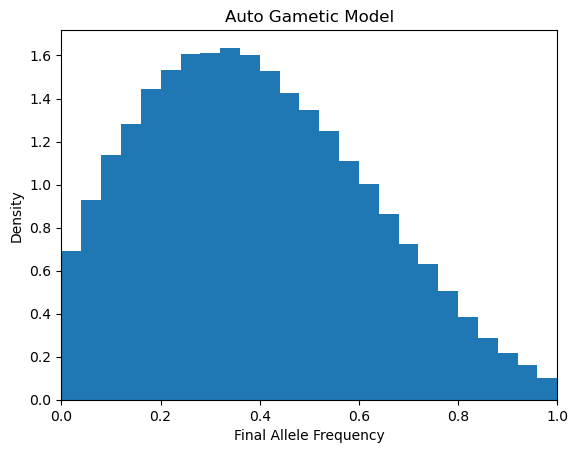

In [5]:
# Test to make sure the gametic and allelic models for autotetraploids give the same results
allele_auto = WF.auto_allelic_WF(N=1000, T = .5, gamma1 = -.5, gamma2=-1, gamma3=-1.5, gamma4=-2, init_q = np.full(100000, .5), replicates = 100000)
gamete_auto = WF.auto_gametic_WF(N=1000, T = .5, gamma1 = -.5, gamma2=-1, gamma3=-1.5, gamma4=-2, init_q = np.full(100000, .5), replicates = 100000)

# extract final frequencies and mask/remove 0 and 1 entries
allele_polymorphic = WF.mask(allele_auto)
# Compute and print mean and variance to compare to the above
print("Allele model results")
print(f"Mean final allele frequency: {np.mean(allele_polymorphic)}")
print(f"Variance of final allele frequency: {np.var(allele_polymorphic)}")

# Plot histogram of final allele frequencies
plt.hist(allele_polymorphic, bins = 25, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Auto Allelic Model')
plt.xlim(0, 1)
plt.show()

# extract final frequencies and mask/remove 0 and 1 entries
gamete_polymorphic = WF.mask(gamete_auto)

# Compute and print mean and variance to compare to the above
print("Gamete model results")
print(f"Mean final allele frequency: {np.mean(gamete_polymorphic)}")
print(f"Variance of final allele frequency: {np.var(gamete_polymorphic)}")

# Plot histogram of final allele frequencies
plt.hist(gamete_polymorphic, bins = 25, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Auto Gametic Model')
plt.xlim(0, 1)
plt.show()

### Validate Diffusion Solution from dadi

Now, let's compare the diffusion solution to the WF model for autos

Retained density (trapz) is: 0.8536950657611414
Mean: 0.5743371478791143
Variance: 0.07226081590602706


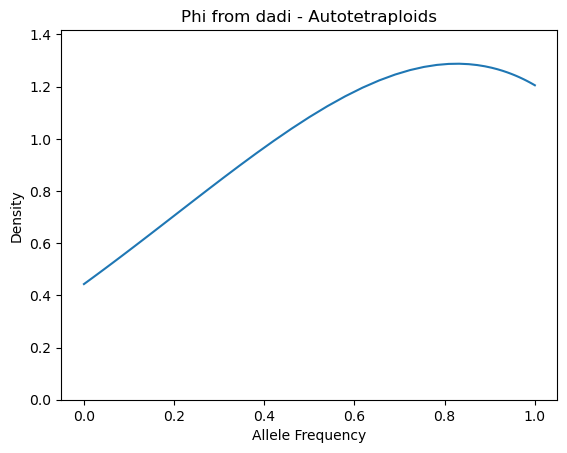

In [4]:
# DIFFUSION MODEL
# Test autos integration in dadi
xx = dadi.Numerics.default_grid(pts=101)

# set up a dirac delta type phi
phi = np.zeros_like(xx)
phi[50] = 1

prelim_density = np.trapz(phi, xx)

# Diploid integration example with dadi
# Note the factors of 2 scaling T and gamma (which would also apply to theta0)
phi = poly_int._one_pop_const_params(phi, xx, T = 1, nu = 1, gamma1 = .25, gamma2=.5, gamma3=.75, gamma4=1, theta0 = 0)

# prints how much mass is retained/not lost at x=0 or x=1 (initial mass = 1)
print(f"Retained density (trapz) is: {np.trapz(phi, xx)/prelim_density}")

WF.summarize_phi(phi, xx, 'Phi from dadi - Autotetraploids')

Retained density is: 0.85363
Mean final allele frequency: 0.5750939780701241
Variance of final allele frequency: 0.07226231705946284


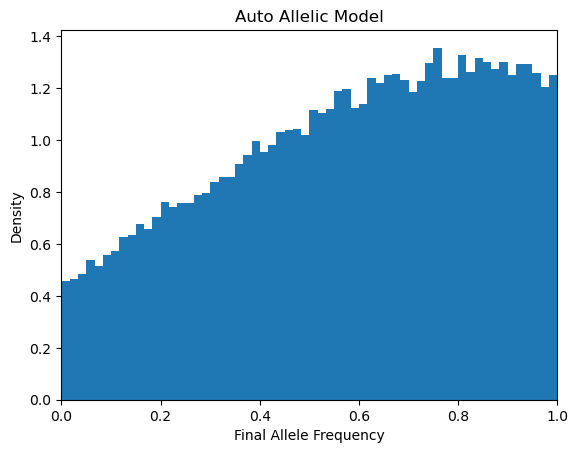

In [63]:
# WF MODEL
# Test to make sure the dadi and WF models for autotetraploids give the same results
allele_auto = WF.auto_allelic_WF(N=1000, T = 1, gamma1 = .25, gamma2=.5, gamma3=.75, gamma4=1, init_q = np.full(100000, .5), replicates = 100000)

# extract final frequencies and mask/remove 0 and 1 entries
allele_polymorphic = WF.mask(allele_auto)

# Compute and print how much mass is retained
print(f"Retained density is: {allele_polymorphic.size / allele_auto.size}")

# Compute and print mean and variance
print(f"Mean final allele frequency: {np.mean(allele_polymorphic)}")
print(f"Variance of final allele frequency: {np.var(allele_polymorphic)}")

# Plot histogram of final allele frequencies
plt.hist(allele_polymorphic, bins = 60, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Auto Allelic Model')
plt.xlim(0, 1)
plt.show()

## Compare Kimura's Analytical Soln. to dadi Numerical Soln.

Here, I adapt the analytical solution from eqn. 4.10 in Kimura (1964) to validate the autotetraploid implementation. Note that Kimura only considers diploids, but under neutrality the only change is the variance term which only affects how the eigenvalues are scaled. So, a single factor of 2 does the trick in getting the correct soln. from Kimura's. See the testing_funcs file for details.

Mean: 0.3887176272019662
Variance: 0.07366831781115157


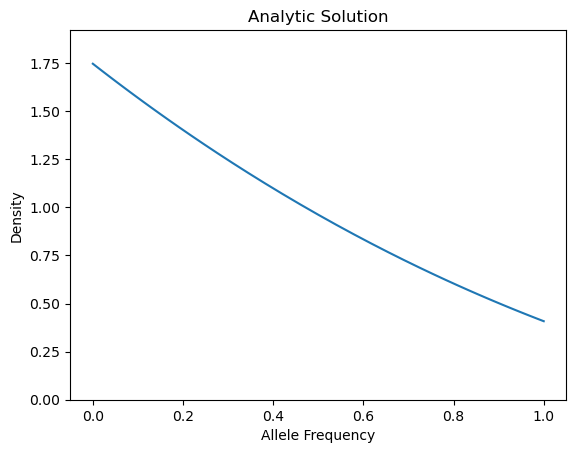

Mean: 0.38739319656597776
Variance: 0.07351179123630042


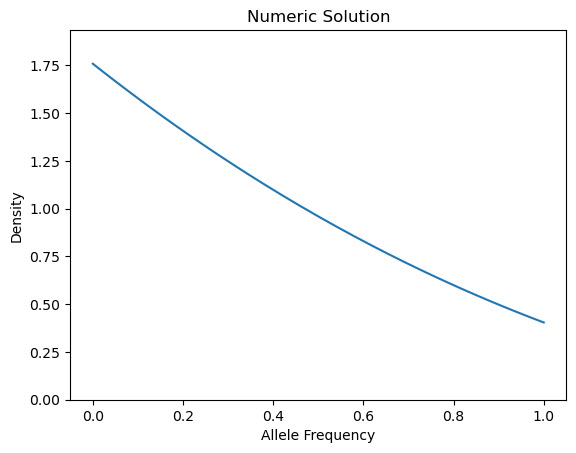

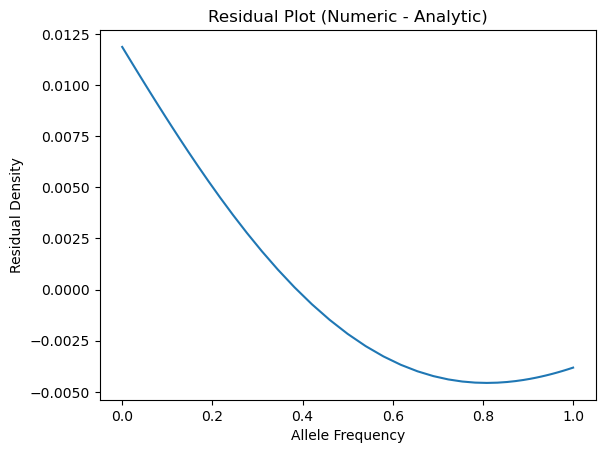

In [9]:
# Here, let's compare to a case with an analytical solution from Kimura
# I will use equation 4.10 from Kimura 1964
xx = dadi.Numerics.default_grid(pts=101)

# value between 1 and 100 which specifies where the Dirac delta IC should be located
# this allows easier editing of the code for testing
index = 6

# Let's define a few parameters so that the time is consistent for the dadi models 
# and we can test multiple different diffusion times
gens = 400
N = 100
T = gens/(2*N)

analytic_soln = kimura_analytic.kimura_neutral_auto(xx, t=gens, p0=xx[index], N=N, max_terms=1000)
WF.summarize_phi(analytic_soln, xx, 'Analytic Solution')


# Now let's compute the solution from dadi
phi1 = np.zeros_like(xx)
# Dirac delta type IC
phi1[index] = 1
phi1 = poly_int._one_pop_const_params(phi1, xx, T=T, theta0=0)

# normalize phi to be a probability density before plotting
WF.summarize_phi(phi1, xx, 'Numeric Solution')

# plot residuals
plt.plot(xx, phi1 - analytic_soln)
plt.xlabel('Allele Frequency')
plt.ylabel('Residual Density')
plt.title('Residual Plot (Numeric - Analytic)')
plt.show()

# Note that Kimura does not explicitly solve for autotetraploids with selection (nor under neutrality)
# but the solution is easily obtained by putting s_auto = s_dip/2 and N_auto = 2*N_dip
# The solution under even genic selection given by Kimura 7.5 is a bit complicated,  
# but I may come back to this to try and work out if the delta_j trick is really an improvement or not


## Investigate How Mass is Conserved with Mutation Injection

This is how I realized some factor of two was missing somewhere, because the solution for autos should conserve density similarly to the diploid solution. 

PROBABILITY MASS RESULTS
Equilibrium: 14.424711848845634
Equilibrium (Auto): 14.424711848845634
After Diploid Integration (theta = 1): 14.447098189829328
After Auto Integration (theta = .5): 7.223549094931995
After Auto Integration (theta = 1): 14.447098189752417
After Auto Integration (theta = 2): 28.894196379504834
Mean: 0.2486042252567762
Variance: 0.12083652507464585


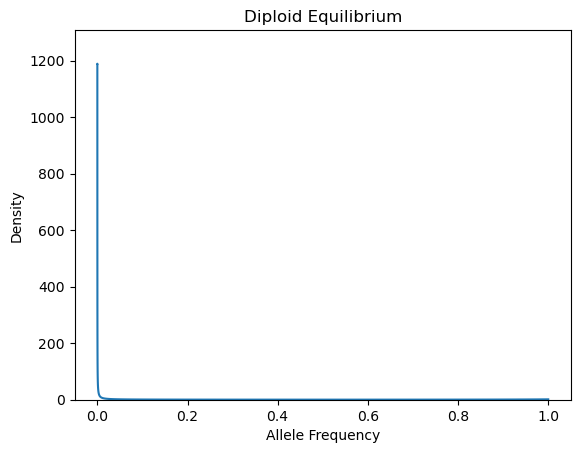

In [ ]:
# Here I want to test how scaling the variance terms and/or theta impacts the integration, 
# specifically how mass is retained
xx = dadi.Numerics.default_grid(pts=101)

phi = dadi.PhiManip.phi_1D(xx, theta0=1, gamma=10)
print("PROBABILITY MASS RESULTS")
print(f"Equilibrium: {np.trapz(phi, xx)}")

# WF.summarize_phi(phi, xx, 'Diploid Equilibrium')

phi_auto=poly_int.phi_1D(xx, nu=1, theta0=1, gamma1=2.5, gamma2=5, gamma3=7.5, gamma4=10)
print(f"Equilibrium (Auto): {np.trapz(phi_auto, xx)}")

# WF.summarize_phi(phi_auto, xx, 'Auto Equilibrium')

# phi_norm /= np.trapz(phi, xx)
# phi_auto /= np.trapz(phi_auto, xx)
# plt.plot(xx, phi_auto - phi_norm)
# plt.xlabel('Allele Frequency')
# plt.ylabel('Density')
# plt.title('Phi Residuals (Autos - Diploids)')
# plt.ylim(1.2*min(phi_auto - phi_norm), 1.2*max(phi_auto - phi_norm))
# plt.show()

phi1 = dadi.Integration._one_pop_const_params(phi, xx, T=10, theta0=1, gamma=10)
print(f"After Diploid Integration (theta = 1): {np.trapz(phi1, xx)}")
# Note here that, because of a doubling of the number of chromosomes, 
# the sum for phi1 should be twice that of phi... at least I think so
# i.e. phi is the equilibrium density for diploids, BUT
# integrating phi with the polyploid integrator (e.g. lower variance)
# changes the equilibrium density so that sum(phi1) = 2*sum(phi)
# This could/should also be corrected for by writing a separate phi_1D function for autos

# to get the same number of chromosomes, you could set nu = .5 for the autopolyploid case, 
# but even then the sum of phi is a bit different... probably because the variance is also affected by nu
# So, instead, let's change the mutation flux controlled by theta0
# because mutations arise twice as frequently in autos, we want to scale theta0 down by a factor of 2
phi2 = poly_int._one_pop_const_params(phi_auto, xx, T=10, theta0=.5, nu=1, gamma1=2.5, gamma2=5, gamma3=7.5, gamma4=10)
print(f"After Auto Integration (theta = .5): {np.trapz(phi2, xx)}")

phi3 = poly_int._one_pop_const_params(phi_auto, xx, T=10, theta0=1, nu=1, gamma1=2.5, gamma2=5, gamma3=7.5, gamma4=10)
print(f"After Auto Integration (theta = 1): {np.trapz(phi3, xx)}")

phi4 = poly_int._one_pop_const_params(phi_auto, xx, T=10, theta0=2, nu=1, gamma1=2.5, gamma2=5, gamma3=7.5, gamma4=10)
print(f"After Auto Integration (theta = 2): {np.trapz(phi4, xx)}")

# let's plot the results to see any differences
# first, normalize the integrated phi's to be a probability density

# WF.summarize_phi(phi2, xx, 'Autotetraploid, \theta = .5')
# WF.summarize_phi(phi3, xx, 'Autotetraploid, \theta = 1')
# WF.summarize_phi(phi4, xx, 'Autotetraploid, \theta = 2')

# phi1 /= np.sum(phi1)
# phi2 /= np.sum(phi2)
# plt.plot(xx, phi2 - phi1)
# plt.xlabel('Allele Frequency')
# plt.ylabel('Density')
# plt.title('Phi Residuals (Autos - Diploids)')
# plt.ylim(1.2*min(phi2 - phi1), 1.2*max(phi2 - phi1))
# plt.show()

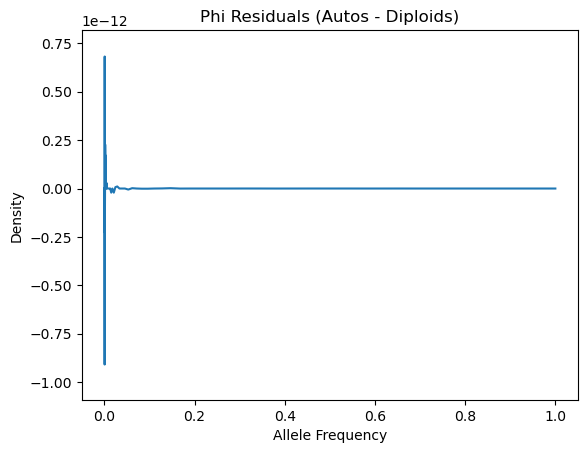

[-7.00187388e+00  1.35820026e+05 -1.15832223e+00 -5.19489012e-01
 -2.68857457e-01 -1.44572419e-01 -7.45286783e-02 -3.18227685e-02
 -4.41372258e-03  1.37883167e-02  2.61464723e-02  3.46449570e-02
  4.05158998e-02  4.45559008e-02  4.72967566e-02  4.91026222e-02
  5.02278387e-02  5.08526813e-02  5.11061832e-02  5.10811219e-02
  5.08440994e-02  5.04424658e-02  4.99091635e-02  4.92661752e-02
  4.85270166e-02  4.76985745e-02  4.67824942e-02  4.57762668e-02
  4.46741294e-02  4.34678687e-02  4.21476076e-02  4.07026418e-02
  3.91223897e-02  3.73975057e-02  3.55211903e-02  3.34906998e-02
  3.13090085e-02  2.89865059e-02  2.65425175e-02  2.40063417e-02
  2.14174179e-02  1.88242365e-02  1.62817206e-02  1.38470832e-02
  1.15745694e-02  9.50991690e-03  7.68563654e-03  6.11816029e-03
  4.80747695e-03  3.73921327e-03  2.88847711e-03  2.22442054e-03
  1.71450660e-03  1.32778966e-03  1.03695294e-03  8.19204842e-04
  6.56332091e-04  5.34247684e-04  4.42314741e-04  3.72635418e-04
  3.19408481e-04  2.78397

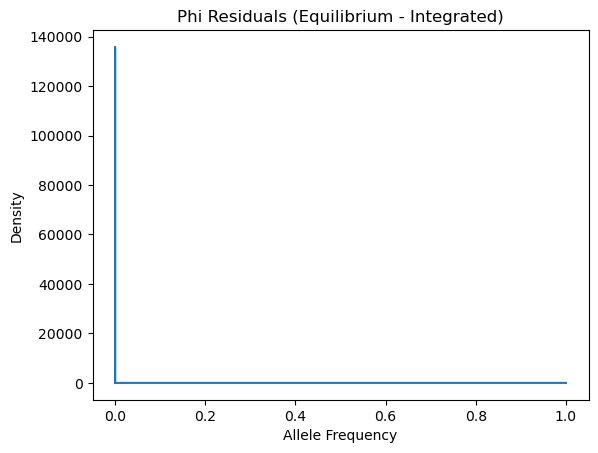

[-7.01211554e+00  1.35820016e+05 -1.16855610e+00 -5.29717952e-01
 -2.79080615e-01 -1.54788798e-01 -8.47371110e-02 -4.20218864e-02
 -1.46019242e-02  3.61290505e-03  1.59860418e-02  2.45020687e-02
  3.03935446e-02  3.44575690e-02  3.72265171e-02  3.90652130e-02
  4.02287698e-02  4.08983498e-02  4.12040027e-02  4.12396651e-02
  4.10732537e-02  4.07536000e-02  4.03153039e-02  3.97821833e-02
  3.91697642e-02  3.84871026e-02  3.77381425e-02  3.69227539e-02
  3.60375585e-02  3.50766306e-02  3.40321443e-02  3.28950371e-02
  3.16557484e-02  3.03050952e-02  2.88353295e-02  2.72414083e-02
  2.55224608e-02  2.36833829e-02  2.17363918e-02  1.97022757e-02
  1.76109736e-02  1.55010855e-02  1.34179872e-02  1.14104596e-02
  9.52611950e-03  7.80636639e-03  6.28186132e-03  4.96956030e-03
  3.87196765e-03  2.97866234e-03  2.26953285e-03  1.71878403e-03
  1.29876897e-03  9.82982553e-04  7.47950625e-04  5.74086413e-04
  4.45775647e-04  3.50995644e-04  2.80725080e-04  2.28318107e-04
  1.88938221e-04  1.59090

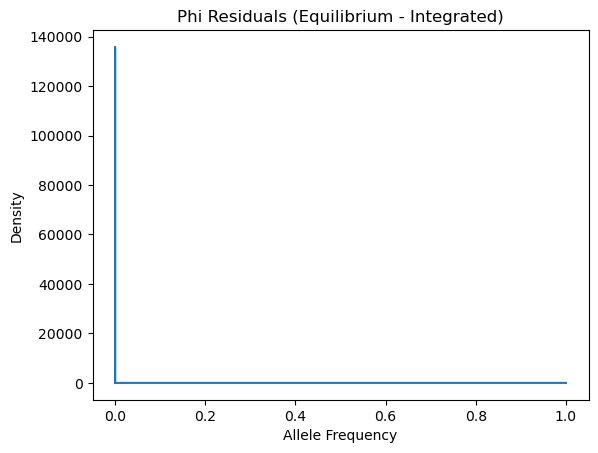

In [ ]:
# Beyond ensuring mass in conserved, we also want to make sure that phi matches the equilibrium solution

# First, we want to see if the auto and diploid equilibrium phi are the same or not

xx = dadi.Numerics.default_grid(pts=101)

phi_dip = dadi.PhiManip.phi_1D(xx, theta0=1, gamma=-4)

phi_auto = poly_int.phi_1D(xx, theta0=1, gamma1=-1, gamma2=-2, gamma3=-3, gamma4=-4)

plt.plot(xx, phi_auto - phi_dip)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Phi Residuals (Autos - Diploids)')
plt.ylim(1.2*min(phi_auto - phi_dip), 1.2*max(phi_auto - phi_dip))
plt.show()

# both equilibrium solutions seem to agree (at least under additivity)

# first, let's test to see what the diploid case looks like
phi_dip_int = dadi.Integration._one_pop_const_params(phi_dip, xx, T=1, gamma=-4, theta0=1)

plt.plot(xx, phi_dip - phi_dip_int)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Phi Residuals (Equilibrium - Integrated)')
plt.show()

# Now let's integrate the auto phi forward and see the results

phi_auto_int = poly_int._one_pop_const_params(phi_auto, xx, T=1, gamma1=-1, gamma2=-2, gamma3=-3, gamma4=-4, theta0=1)

plt.plot(xx, phi_auto - phi_auto_int)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Phi Residuals (Equilibrium - Integrated)')
plt.show()


## Compare Response to Selection in Diploids and Autotetraploids on Short Time Scales

Here, I want to compare how the mean of phi changes in response to positive or purifying selection over short time scales. In particular, I want to see if the response to selection is smaller or the same in autotetraploids and by what factor this response differs by.

MODERATE PURIFYING
Diploid average is 0.475189515971402
Autotetraploid average is 0.48755414152955856
MODERATE POSITIVE
Diploid average is 0.6194568121004724
Autotetraploid average is 0.5613381462829795
Mean: 0.4475744341985535
Variance: 0.05171387301454858


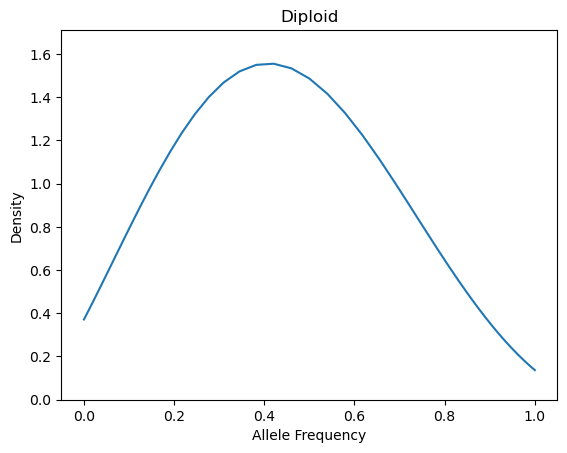

Mean: 0.4707260256425372
Variance: 0.02917130365722881


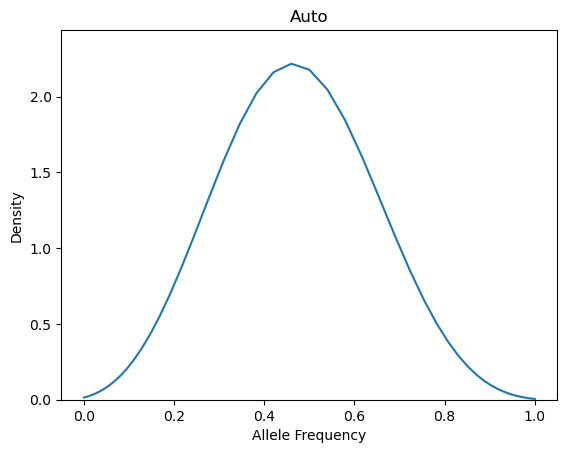

In [13]:
# Here I want to test how the allele frequency change differs between autos and diploids when integrated in dadi
# I would expect the autos to respond to selection half as much, so the change from the initial density should be half as large

# first, let's set up a grid
xx = dadi.Numerics.default_grid(pts=101)
# set up a Dirac delta distributed phi to start from
phi = np.zeros_like(xx)
phi[50] = 1

# let's integrate the diploid case
phi_dip = dadi.Integration._one_pop_const_params(phi, xx, T = .01, gamma = -10, theta0=0)
# and the auto case
phi_auto = poly_int._one_pop_const_params(phi, xx, T = .01, gamma1=-2.5, gamma2=-5, gamma3=-7.5, gamma4=-10, theta0=0)

# let's calculate the mean value in the resulting phis
# to do so, we first need to normalize them to be probability densities (since theta0=0)
phi_dip /= np.trapz(phi_dip, xx)
phi_auto /= np.trapz(phi_auto, xx)
# compute E[X]
print("MODERATE PURIFYING")
print(f"Diploid average is {np.trapz(phi_dip*xx, xx)}")
print(f"Autotetraploid average is {np.trapz(phi_auto*xx, xx)}")

# That seems roughly accurate on short time scales (the issue is that for large T, most of the mass ends up lost, especially in the diploids)

# Let's test positive selection too

# let's integrate the diploid case
phi_dip = dadi.Integration._one_pop_const_params(phi, xx, T = .05, gamma = 10, theta0=0)
# and the auto case
phi_auto = poly_int._one_pop_const_params(phi, xx, T = .05, gamma1=2.5, gamma2=5, gamma3=7.5, gamma4=10, theta0=0)

# let's calculate the mean value in the resulting phis
# to do so, we first need to normalize them to be probability densities (since theta0=0)
phi_dip /= np.trapz(phi_dip, xx)
phi_auto /= np.trapz(phi_auto, xx)
# compute E[X]
print("MODERATE POSITIVE")
print(f"Diploid average is {np.trapz(phi_dip*xx, xx)}")
print(f"Autotetraploid average is {np.trapz(phi_auto*xx, xx)}")

# and let's test weak purifying selection at slightly longer time scales
# let's integrate the diploid case
phi_dip = dadi.Integration._one_pop_const_params(phi, xx, T = .25, gamma = -1, theta0=0)
# and the auto case
phi_auto = poly_int._one_pop_const_params(phi, xx, T = .25, gamma1=-.25, gamma2=-.5, gamma3=-.75, gamma4=-1, theta0=0)

WF.summarize_phi(phi_dip, xx, 'Diploid')
WF.summarize_phi(phi_auto, xx, 'Auto')




## Compare Mass Retention in Diploids and Autotetraploids

Here, I want to validate that mass is lost more slowly in the autotetraploids due to slower effective drift in the autos. 

In [85]:
# Here, I want to compare how much density is retained under neutrality

# first, let's set up a grid
xx = dadi.Numerics.default_grid(pts=101)
# set up a Dirac delta distributed phi to start from
phi = np.zeros_like(xx)
phi[50] = 1

# let's integrate the diploid case
phi_dip = dadi.Integration._one_pop_const_params(phi, xx, T = 1, gamma = 0, theta0=0)
# and the auto case
phi_auto = poly_int._one_pop_const_params(phi, xx, T = 1, gamma1=0, gamma2=0, gamma3=0, gamma4=0, theta0=0)
phi_auto2 = poly_int._one_pop_const_params(phi, xx, T = 2, gamma1=0, gamma2=0, gamma3=0, gamma4=0, theta0=0)

# let's see how much mass is retained
print(f"Retained density in diploid (T=1) is {np.trapz(phi_dip, xx)/np.trapz(phi, xx)}")
print(f"Retained density in auto (T=1) is {np.trapz(phi_auto, xx)/np.trapz(phi, xx)}") 
print(f"Retained density in auto (T=2) is {np.trapz(phi_auto2, xx)/np.trapz(phi, xx)}") 


Retained density in diploid (T=1) is 0.5509998043369281
Retained density in auto (T=1) is 0.866435918466202
Retained density in auto (T=2) is 0.5505308432616459
